<a href="https://colab.research.google.com/github/HernanDL/Noise-Cancellation-Using-ML/blob/main/Electric_Engine_Noise_Cancellation_using_Deep_Learning_(TCN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Electric Engine Noise Cancellation using Deep Learning

### Introduction
This notebook implements an adaptive noise cancellation system specifically designed for electric engine noise in the frequency range of 20-8000 Hz. The approach uses deep learning to predict and generate anti-noise signals for destructive interference.

Key features:
- Processes 4-second audio recordings
- Uses Temporal Convolutional Network (TCN) architecture, which can be more efficient for sequence processing tasks like noise cancellation. The TCN will maintain the sequence length of 4 while providing faster processing and good noise cancellation performance.
- Includes frequency domain analysis
- Provides visualization of results in time and frequency domains
- Exports trained model for local deployment

#### LLM Assisted: Claude 3.5 Sonnet

### Setup and Dependencies

In [88]:
# Basic dependencies
!pip install librosa
!pip install soundfile
!pip install IPython
!pip install matplotlib
!pip install numpy
!pip install tensorflow
!pip install scipy
!apt-get -qq install -y graphviz && pip install pydot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.4 MB/s eta 0:00:00


In [89]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import soundfile as sf
from IPython.display import Audio, display
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, Dense, Dropout, Input, LayerNormalization
from scipy import signal
import os
import json
import pydot
from IPython.display import Image, display
from tensorflow.keras import models, layers

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Enable GPU if available
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

GPU Available:  []


### Audio Processing & Data Preparation Utilities

In [87]:
class AudioProcessor:
    def __init__(self, sample_rate=44100):
        self.sample_rate = sample_rate

    def load_audio(self, file_path):
        """Load audio file and resample if necessary"""
        audio, sr = librosa.load(file_path, sr=self.sample_rate)
        if len(audio) > 4 * self.sample_rate:  # Trim to 4 seconds
            audio = audio[:4 * self.sample_rate]
        elif len(audio) < 4 * self.sample_rate:  # Pad if shorter
            padding = np.zeros(4 * self.sample_rate - len(audio))
            audio = np.concatenate([audio, padding])
        return audio

    def get_frequency_spectrum(self, audio):
        """Calculate frequency spectrum"""
        frequencies = np.fft.fftfreq(len(audio), 1/self.sample_rate)
        spectrum = np.abs(np.fft.fft(audio))
        return frequencies[:len(frequencies)//2], spectrum[:len(spectrum)//2]

    def calculate_db(self, audio):
        """Convert amplitude to decibels"""
        return 20 * np.log10(np.abs(audio) + 1e-10)

    def plot_waveform(self, audio, title="Waveform"):
        """Plot audio waveform"""
        plt.figure(figsize=(12, 4))
        plt.plot(np.arange(len(audio))/self.sample_rate, audio)
        plt.title(title)
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.grid(True)
        plt.show()

    def plot_spectrum(self, audio, title="Frequency Spectrum"):
        """Plot frequency spectrum"""
        freqs, spectrum = self.get_frequency_spectrum(audio)
        plt.figure(figsize=(12, 4))
        plt.semilogx(freqs[1:], spectrum[1:])
        plt.title(title)
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Magnitude")
        plt.grid(True)
        plt.show()

    def calculate_cutoff_frequency(self, audio, desired_retention=95):
        # Perform FFT (Fast Fourier Transform) to get frequency components
        fft = np.fft.fft(audio)
        frequencies = np.fft.fftfreq(len(fft), 1/self.sample_rate)

        # Calculate the magnitude spectrum
        magnitude = np.abs(fft)

        # Filter positive frequencies only (since FFT is symmetric)
        positive_frequencies = frequencies[:len(frequencies)//2]
        magnitude = magnitude[:len(magnitude)//2]

        # Sort frequencies by magnitude (descending order of energy contribution)
        sorted_indices = np.argsort(positive_frequencies)
        sorted_frequencies = positive_frequencies[sorted_indices]
        sorted_magnitude = magnitude[sorted_indices]

        # Calculate cumulative energy of the signal
        cumulative_energy = np.cumsum(sorted_magnitude)
        total_energy = np.sum(sorted_magnitude)

        # Normalize the cumulative energy to a percentage
        cumulative_energy_percentage = (cumulative_energy / total_energy) * 100

        # Find the cutoff frequency where the desired retention is reached
        # Use argmax to find the closest index if 100% is not reached
        cutoff_index = np.argmax(cumulative_energy_percentage >= desired_retention)

        # If cutoff_index is 0 and desired_retention is not reached, use the last index
        if cutoff_index == 0 and cumulative_energy_percentage[cutoff_index] < desired_retention:
            cutoff_index = len(sorted_frequencies) - 1

        cutoff_frequency = sorted_frequencies[cutoff_index]

        print(f"Cutoff frequency for {desired_retention}% retention: {cutoff_frequency:.2f} Hz")

        # Plot the cumulative energy curve
        plt.figure(figsize=(10, 5))
        plt.plot(sorted_frequencies, cumulative_energy_percentage, label="Cumulative Energy")
        plt.axhline(y=desired_retention, color='r', linestyle='--', label=f"{desired_retention}% Retention")
        plt.axvline(x=cutoff_frequency, color='g', linestyle='--', label=f"Cutoff Frequency = {cutoff_frequency:.2f} Hz")
        plt.title("Cumulative Energy vs. Frequency")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Cumulative Energy (%)")
        plt.legend()
        plt.grid(True)
        plt.show()

        return cutoff_frequency

class DataPreparator:
    def __init__(self, sequence_length=32, sample_rate=44100):
        self.sequence_length = sequence_length
        self.sample_rate = sample_rate

    def prepare_sequences(self, audio):
        """Create sequences for training"""
        X, y = [], []
        for i in range(len(audio) - self.sequence_length):
            X.append(audio[i:i + self.sequence_length])
            y.append(-audio[i + self.sequence_length])  # Negative for cancellation
        return np.array(X), np.array(y)

    def augment_data(self, audio, n_augmentations=5):
        """Create augmented versions of the audio"""
        augmented = []
        for _ in range(n_augmentations):
            # Add slight amplitude variation
            amp_variation = 1.0 + np.random.normal(0, 0.01)
            # Add slight phase variation
            phase_variation = np.random.normal(0, 0.01)
            # Add ambient noise
            ambient_noise = np.random.normal(0, 0.005, len(audio))

            aug_audio = audio * amp_variation + phase_variation + ambient_noise
            augmented.append(aug_audio)

        return np.concatenate([audio[np.newaxis, :]] + [aug[np.newaxis, :] for aug in augmented])

### Model Architecture

In [110]:
class NoiseCANCModel:
    def __init__(self, sequence_length=16, epochs=2, batch_size=32, learning_rate=0.001):
        self.sequence_length = sequence_length
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.model = self._build_model()

        print("Model initialized with sequence length:", sequence_length)
        print("Model initialized with epochs:", epochs)
        print("Model initialized with batch size:", batch_size)
        print("Model initialized with learning rate:", learning_rate)

    def _build_model(self):

        input_layer = layers.Input(shape=(self.sequence_length, 1))

        # First TCN block with optimized filters
        tcn = layers.Conv1D(filters=8, kernel_size=3, padding='causal', activation='relu', dilation_rate=1)(input_layer)
        tcn = layers.BatchNormalization()(tcn)
        tcn = layers.Conv1D(filters=8, kernel_size=3, padding='causal', activation='relu', dilation_rate=2)(tcn)
        tcn = layers.BatchNormalization()(tcn)

        # Second TCN block with reduced filter size
        tcn = layers.Conv1D(filters=16, kernel_size=3, padding='causal', activation='relu', dilation_rate=4)(tcn)
        tcn = layers.BatchNormalization()(tcn)

        # Flatten and dense layers with fewer units for faster inference
        flatten = layers.Flatten()(tcn)
        dense = layers.Dense(8, activation='relu')(flatten)  # Reduced to 8 units

        # Output layer to predict a single continuous value
        output_layer = layers.Dense(1, activation='tanh')(dense)

        model = models.Model(inputs=input_layer, outputs=output_layer)

        #optimizer = tf.keras.optimizers.RMSprop(learning_rate=self.learning_rate)

        # Use Adam optimizer with gradient clipping
        optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate, clipnorm=1.0)

        model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

        return model

    def train(self, X, y, validation_split=0.2):
        callbacks = [
            EarlyStopping(patience=1, restore_best_weights=True),
            ReduceLROnPlateau(factor=0.5, patience=1, min_lr=1e-6)
        ]

        history = self.model.fit(
            X, y,
            validation_split=validation_split,
            epochs=self.epochs,
            batch_size=self.batch_size,
            callbacks=callbacks,
            verbose=1
        )

        return history

    def printModelSummary(self):
        self.model.summary()

        print("")
        print("Model Architecture")

        # Extract the number of neurons per layer along with the layer type and output shape
        layers_info = []
        for layer in self.model.layers:
            # Extract relevant information based on layer type
            layer_type = layer.__class__.__name__
            if hasattr(layer, 'units'):  # Dense layers
                layers_info.append((layer.units, layer_type))
            elif hasattr(layer, 'filters'):  # Conv1D layers
                layers_info.append((layer.filters, layer_type))
            elif hasattr(layer, 'output_shape') and isinstance(layer.output_shape, tuple):
                # Use the output shape's last dimension for non-Dense, non-Conv layers
                layers_info.append((layer.output_shape[-1], layer_type))

        # Create a new directed graph with a left-to-right layout
        graph = pydot.Dot(graph_type='digraph', rankdir='TD')

        # Track the previous layer nodes for creating edges
        previous_layer_nodes = []

        # Loop through each layer and add nodes
        for i, (layer_size, layer_type) in enumerate(layers_info):
            current_layer_nodes = []
            for j in range(layer_size):
                # Create a node for each neuron/feature map in the layer
                node = pydot.Node(
                    f'{layer_type} {i} Neuron {j}',
                    label='',
                    shape='circle' if 'Dense' in layer_type else 'box',
                    style='filled',
                    fillcolor='lightblue' if 'Dense' in layer_type else 'lightgreen',
                    width='0.2' if 'Dense' in layer_type else '0.4',
                    height='0.2' if 'Dense' in layer_type else '0.4'
                )
                graph.add_node(node)
                current_layer_nodes.append(node)

            # Create a label node for the layer type
            layer_label_node = pydot.Node(
                f'{layer_type} {i}',
                label=f'{layer_type}\nOutput: {layer_size}',
                shape='box',
                style='filled',
                fillcolor='lightgrey',
                fontsize='12',
                fontcolor='black'
            )
            graph.add_node(layer_label_node)

            # Connect the label node to all neurons in the current layer
            for node in current_layer_nodes:
                graph.add_edge(pydot.Edge(layer_label_node, node, color='gray'))

            # If this is not the first layer, add edges between previous and current layer nodes
            if previous_layer_nodes:
                for prev_node in previous_layer_nodes:
                    for curr_node in current_layer_nodes:
                        edge = pydot.Edge(prev_node, curr_node)
                        graph.add_edge(edge)

            # Update the previous layer nodes
            previous_layer_nodes = current_layer_nodes

        # Save the graph to a PNG file
        graph.write_png('tcn_neural_network.png')

        # Display the image in the notebook
        display(Image('tcn_neural_network.png', retina=True))

    def predict(self, X):
        return self.model.predict(X)

    def save(self, path):
        self.model.save(path)

    @classmethod
    def load(cls, path):
        instance = cls()
        instance.model = load_model(path)
        return instance


### Training & Visualization

In [109]:
class NoiseCANCTrainer:
    def __init__(self, sequence_length=32, sample_rate=44100):
        self.sequence_length = sequence_length
        self.sample_rate = sample_rate
        self.processor = AudioProcessor(sample_rate)
        self.preparator = DataPreparator(sequence_length, sample_rate)
        self.model = NoiseCANCModel(sequence_length)
        self.model.printModelSummary()
        print("Training initialized with sample rate:", sample_rate)

    def train_on_audio(self, audio, n_augmentations=5):
        """Train the model on audio data with augmentations"""
        # Normalize audio
        audio = audio / np.max(np.abs(audio))

        # Create augmented versions
        augmented_data = self.preparator.augment_data(audio, n_augmentations)

        # Prepare sequences for each augmented version
        X_all, y_all = [], []
        for aug_audio in augmented_data:
            X, y = self.preparator.prepare_sequences(aug_audio)
            X_all.append(X)
            y_all.append(y)

        X_train = np.concatenate(X_all)
        y_train = np.concatenate(y_all)

        # Train model
        history = self.model.train(X_train, y_train)
        return history

    def generate_anti_noise(self, audio):
        """Generate anti-noise signal for the input audio"""
        # Normalize audio
        audio = audio / np.max(np.abs(audio))

        # Prepare sequences
        X, _ = self.preparator.prepare_sequences(audio)
        X = X.reshape(-1, self.sequence_length, 1)

        # Predict anti-noise
        anti_noise = self.model.predict(X)

        # Pad beginning (due to sequence_length)
        padding = np.zeros(self.sequence_length)
        anti_noise = np.concatenate([padding, anti_noise.flatten()])

        return anti_noise[:len(audio)]

    def save_model(self, path="noise_canc_model"):
        """Save model and parameters"""
        os.makedirs(path, exist_ok=True)

        # Save model
        self.model.save(os.path.join(path, "model.keras"))

        # Save parameters
        params = {
            "sequence_length": self.sequence_length,
            "sample_rate": self.sample_rate
        }
        with open(os.path.join(path, "params.json"), "w") as f:
            json.dump(params, f)

        # Create zip file
        !zip -r {path}.zip {path}

        # Download zip file
        from google.colab import files
        files.download(f"{path}.zip")

class ResultsVisualizer:
    def __init__(self, sample_rate=44100):
        self.processor = AudioProcessor(sample_rate)

    def plot_results(self, original, anti_noise, combined):
        """Plot comprehensive results"""
        # Time domain plots
        plt.figure(figsize=(15, 12))

        # Original signal
        plt.subplot(4, 1, 1)
        plt.plot(np.arange(len(original))/self.processor.sample_rate, original)
        plt.title("Original Noise")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.grid(True)

        # Anti-noise signal
        plt.subplot(4, 1, 2)
        plt.plot(np.arange(len(anti_noise))/self.processor.sample_rate, anti_noise)
        plt.title("Generated Anti-noise")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.grid(True)

        # Combined signal
        plt.subplot(4, 1, 3)
        plt.plot(np.arange(len(combined))/self.processor.sample_rate, combined)
        plt.title("Residual Noise (Combined)")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.grid(True)

        # Spectrum comparison
        plt.subplot(4, 1, 4)
        freqs_orig, spec_orig = self.processor.get_frequency_spectrum(original)
        freqs_comb, spec_comb = self.processor.get_frequency_spectrum(combined)

        plt.semilogx(freqs_orig[1:], self.processor.calculate_db(spec_orig[1:]),
                    label="Original", alpha=0.7)
        plt.semilogx(freqs_comb[1:], self.processor.calculate_db(spec_comb[1:]),
                    label="Residual", alpha=0.7)
        plt.title("Frequency Spectrum Comparison")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Magnitude (dB)")
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()

        # Print noise reduction statistics
        self.print_reduction_stats(original, combined)

    def print_reduction_stats(self, original, combined):
        """Calculate and print noise reduction statistics"""
        # Calculate RMS values
        rms_orig = np.sqrt(np.mean(original**2))
        rms_comb = np.sqrt(np.mean(combined**2))

        # Calculate reduction in dB
        reduction_db = 20 * np.log10(rms_comb/rms_orig)

        print(f"\nNoise Reduction Statistics:")
        print(f"Original RMS: {rms_orig:.4f}")
        print(f"Residual RMS: {rms_comb:.4f}")
        print(f"Reduction: {-reduction_db:.1f} dB")

### Upload Training File & Analize

Step 1: Upload audio file
Please upload a 4-second audio file of electric engine noise...


Saving extractor_44k.wav to extractor_44k (1).wav


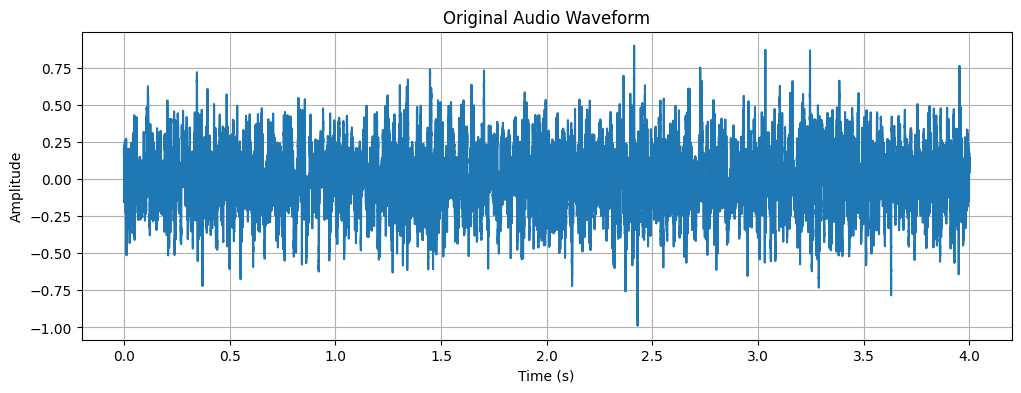

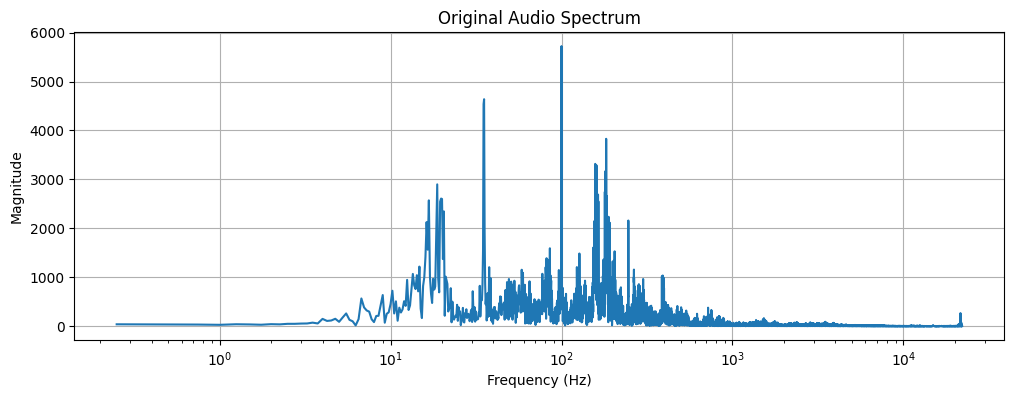

Cutoff frequency for 95% retention: 14855.50 Hz


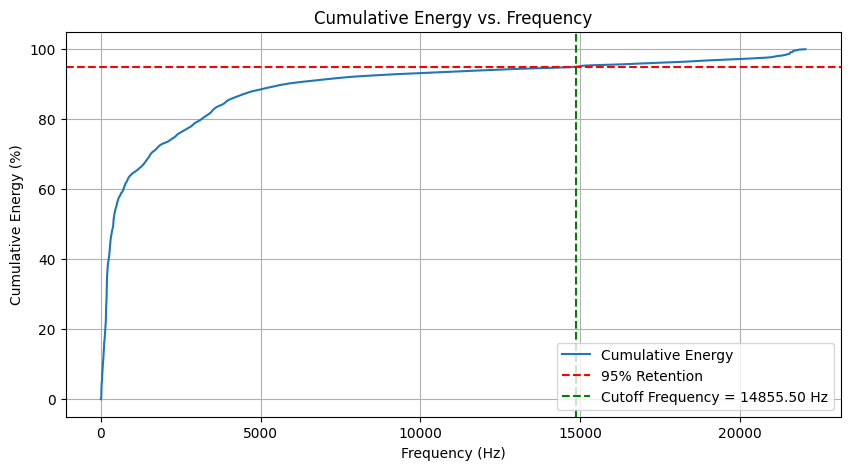

In [9]:
from google.colab import files

def upload_and_process_audio():
    """Upload and process audio file"""
    print("Please upload a 4-second audio file of electric engine noise...")
    uploaded = files.upload()

    if not uploaded:
        raise ValueError("No file was uploaded")

    file_name = list(uploaded.keys())[0]

    # Process audio
    processor = AudioProcessor()
    audio = processor.load_audio(file_name)

    # Plot original audio
    processor.plot_waveform(audio, "Original Audio Waveform")
    processor.plot_spectrum(audio, "Original Audio Spectrum")
    processor.calculate_cutoff_frequency(audio)

    return audio, processor

# Upload and process audio
print("Step 1: Upload audio file")
audio, processor = upload_and_process_audio()

### Complete Implementation Example


Step 2: Training model
Model initialized with sequence length: 4
Model initialized with epochs: 2
Model initialized with batch size: 32
Model initialized with learning rate: 0.001


Model: "functional_111"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_44 (InputLayer)          │ (None, 4, 1)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_73 (Conv1D)                   │ (None, 4, 8)                │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_58               │ (None, 4, 8)                │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_74 (Conv1D)                   │ (None, 4, 8)                │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_59               │ (None, 4, 8)                │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_75 (Conv1D)                   │ (None, 4, 16)               │             400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_60               │ (None, 4, 16)               │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_19 (Flatten)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_80 (Dense)                     │ (None, 8)                   │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_81 (Dense)                     │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,289 (5.04 KB)

 Trainable params: 1,225 (4.79 KB)

 Non-trainable params: 64 (256.00 B)


Model Architecture


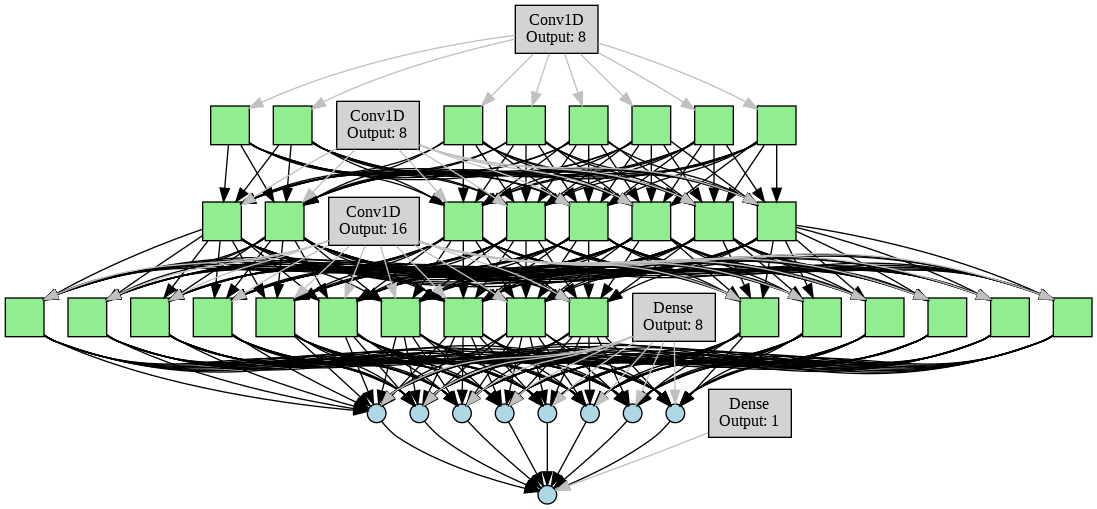

Training initialized with sample rate: 44100
Epoch 1/2
26460/26460 ━━━━━━━━━━━━━━━━━━━━ 144s 5ms/step - loss: 0.0036 - mae: 0.0298 - val_loss: 3.4253e-04 - val_mae: 0.0145 - learning_rate: 0.0010
Epoch 2/2
26460/26460 ━━━━━━━━━━━━━━━━━━━━ 138s 5ms/step - loss: 2.5489e-04 - mae: 0.0124 - val_loss: 2.3940e-04 - val_mae: 0.0119 - learning_rate: 0.0010

Step 3: Generating anti-noise
5513/5513 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step

Step 4: Visualizing results


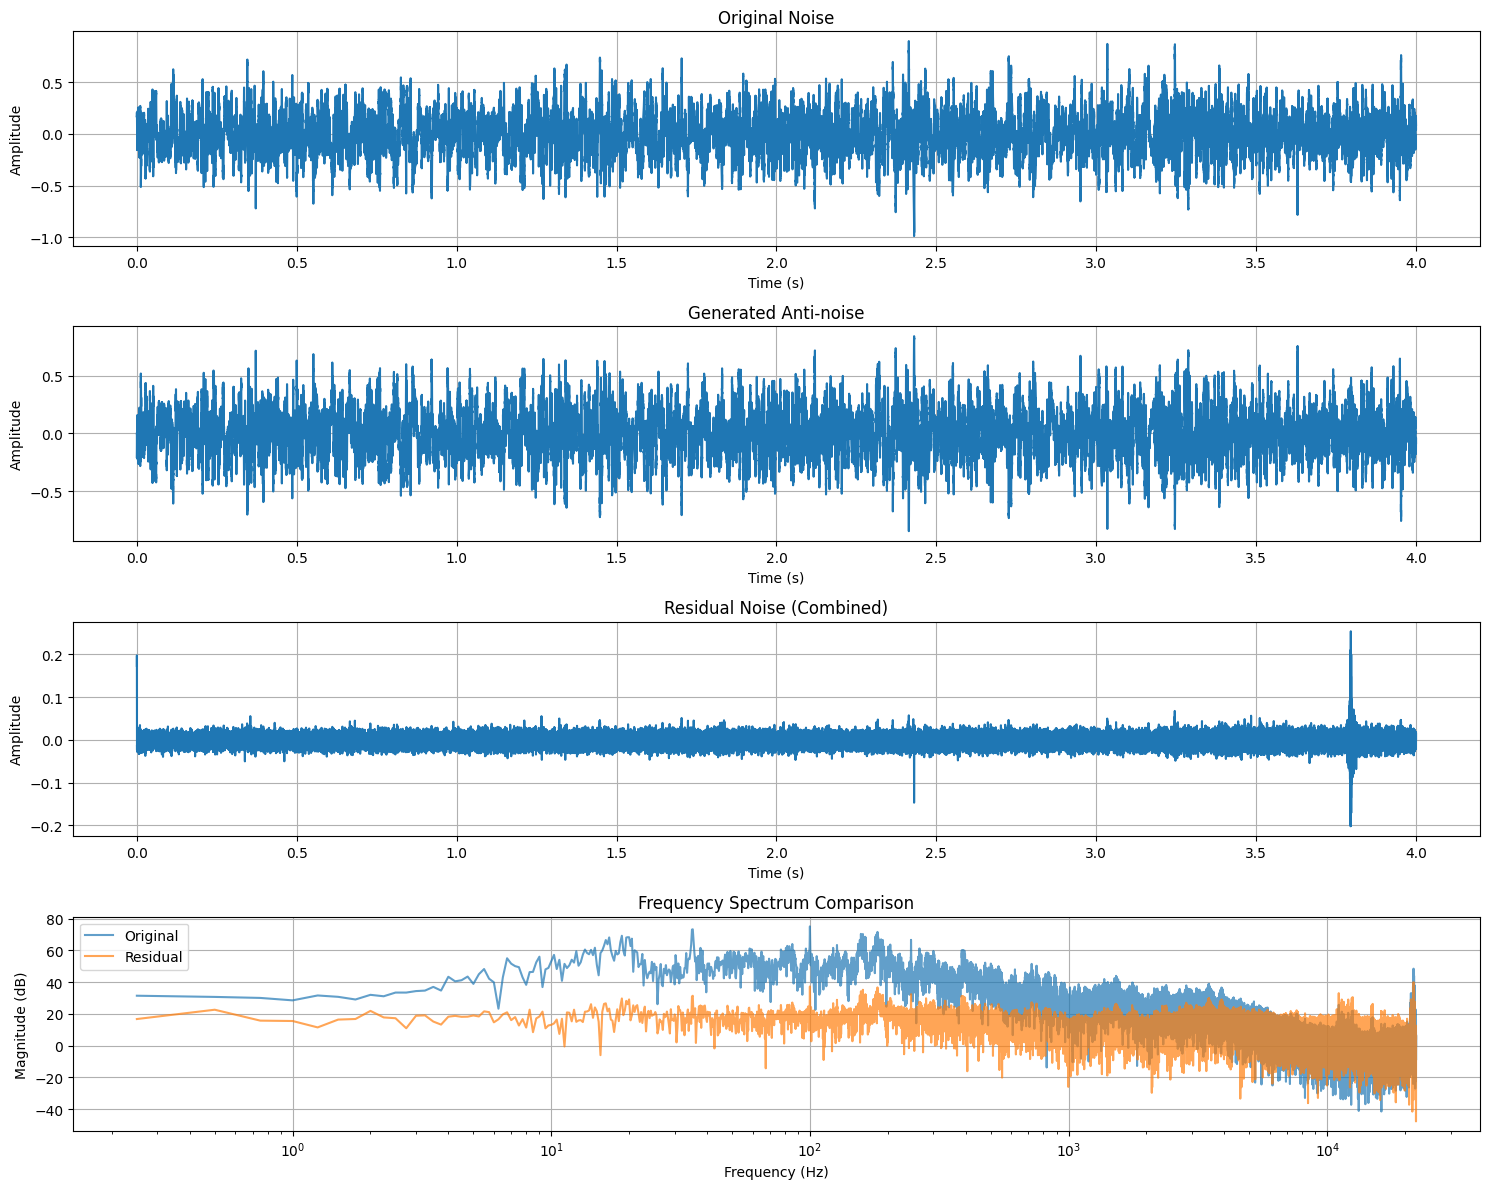


Noise Reduction Statistics:
Original RMS: 0.2090
Residual RMS: 0.0115
Reduction: 25.2 dB

Step 5: Saving model
updating: noise_canc_model/ (stored 0%)
updating: noise_canc_model/model.keras (deflated 82%)
updating: noise_canc_model/params.json (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Step 6: Audio playback
Original audio:


Residual noise:


In [111]:
def main():
    # Create trainer
    print("\nStep 2: Training model")
    trainer = NoiseCANCTrainer(sequence_length=4)
    history = trainer.train_on_audio(audio)

    # Generate anti-noise
    print("\nStep 3: Generating anti-noise")
    anti_noise = trainer.generate_anti_noise(audio)

    # Combine signals
    combined = audio + anti_noise

    # Visualize results
    print("\nStep 4: Visualizing results")
    visualizer = ResultsVisualizer()
    visualizer.plot_results(audio, anti_noise, combined)

    # Save and download model
    print("\nStep 5: Saving model")
    trainer.save_model()

    # Play audio examples
    print("\nStep 6: Audio playback")
    print("Original audio:")
    display(Audio(audio, rate=44100))
    print("Residual noise:")
    display(Audio(combined, rate=44100))

# Run the complete example
if __name__ == "__main__":
    main()

### Usage Notes:

1. Upload Requirements:
   - 4-second audio file
   - Sample rate: 44100 Hz
   - Single channel (mono)

2. Training Parameters:   
   - 5 augmented versions of input
   - Early stopping
   - Learning rate reduction on plateau

3. Model Export:
   - Saves as zip file containing:
     - Model weights (.keras)
     - Parameters (params.json)
   - Includes local deployment code

4. Performance Metrics:
   - Shows time-domain waveforms
   - Displays frequency spectra
   - Calculates noise reduction in dB
   - Provides audio playback

### Local Deployment Code
Save this as `local_inference.py` for running the model locally:

In [ ]:
import numpy as np
import tensorflow as tf
import pyaudio
import wave
import threading
import queue
import time
from collections import deque
import sounddevice as sd
import logging
import os

class RealTimeNoiseCancel:
    def __init__(self, model_path, sequence_length=4):
        self.sequence_length = sequence_length
        self.model = self._load_model(model_path)

        # Audio configuration
        self.chunk_size = 1024
        self.format = pyaudio.paFloat32
        self.channels = 1
        self.rate = 44100
        self.latency = 'low'  # for sounddevice

        # Buffers and queues
        self.input_queue = queue.Queue(maxsize=10)
        self.output_queue = queue.Queue(maxsize=10)
        self.signal_buffer = deque(maxlen=sequence_length)

        # Processing flags
        self.is_running = False
        self.save_output = False
        self._setup_logging()

    def _setup_logging(self):
        """Setup logging for debugging"""
        logging.basicConfig(
            filename='noise_cancellation.log',
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s'
        )

    def _load_model(self, model_path):
        """Load and optimize the trained model"""
        try:
            # Try loading TFLite model first
            interpreter = tf.lite.Interpreter(model_path=model_path)
            interpreter.allocate_tensors()
            logging.info("Loaded TFLite model successfully")
            return interpreter
        except Exception as e:
            logging.warning(f"Failed to load TFLite model: {e}")
            try:
                # Fall back to full model
                model = tf.keras.models.load_model(model_path)
                logging.info("Loaded full Keras model successfully")
                return model
            except Exception as e:
                logging.error(f"Failed to load model: {e}")
                raise

    def _process_audio_chunk(self, indata, outdata, frames, time, status):
        """Callback for sounddevice stream"""
        if status:
            logging.warning(f"Audio callback status: {status}")

        # Add input data to buffer
        self.signal_buffer.extend(indata.flatten())

        if len(self.signal_buffer) >= self.sequence_length:
            # Prepare input for model
            input_data = np.array(list(self.signal_buffer))
            input_data = input_data.reshape(1, self.sequence_length, 1)

            try:
                # Make prediction
                if isinstance(self.model, tf.lite.Interpreter):
                    input_details = self.model.get_input_details()
                    output_details = self.model.get_output_details()
                    self.model.set_tensor(input_details[0]['index'], input_data)
                    self.model.invoke()
                    prediction = self.model.get_tensor(output_details[0]['index'])
                else:
                    prediction = self.model.predict(input_data, verbose=0)

                # Apply prediction to output buffer
                outdata[:] = prediction.reshape(-1, 1)

                # Save output if enabled
                if self.save_output:
                    self.output_queue.put(prediction.copy())

            except Exception as e:
                logging.error(f"Error in audio processing: {e}")
                outdata.fill(0)
        else:
            outdata.fill(0)

    def _save_output_thread(self):
        """Thread for saving processed audio"""
        with wave.open('processed_output.wav', 'wb') as wf:
            wf.setnchannels(self.channels)
            wf.setsampwidth(4)  # Float32
            wf.setframerate(self.rate)

            while self.is_running:
                try:
                    data = self.output_queue.get(timeout=1)
                    wf.writeframes(data.astype(np.float32).tobytes())
                except queue.Empty:
                    continue
                except Exception as e:
                    logging.error(f"Error saving output: {e}")

    def start(self, save_output=False):
        """Start real-time noise cancellation"""
        self.is_running = True
        self.save_output = save_output

        # Start output saving thread if enabled
        if save_output:
            save_thread = threading.Thread(target=self._save_output_thread)
            save_thread.daemon = True
            save_thread.start()

        try:
            # Start audio stream
            with sd.Stream(
                channels=self.channels,
                samplerate=self.rate,
                blocksize=self.chunk_size,
                dtype=np.float32,
                latency=self.latency,
                callback=self._process_audio_chunk
            ) as stream:
                logging.info("Started audio stream")

                while self.is_running:
                    time.sleep(0.1)

        except Exception as e:
            logging.error(f"Error in audio stream: {e}")
            self.is_running = False
            raise

    def stop(self):
        """Stop noise cancellation"""
        self.is_running = False
        logging.info("Stopped noise cancellation")

# Example usage
if __name__ == "__main__":
    # Initialize noise cancellation system
    noise_canceller = RealTimeNoiseCancel(
        model_path='noise_cancellation_model.tflite',  # or .h5
        sequence_length=4
    )

    try:
        # Start processing with output saving enabled
        noise_canceller.start(save_output=True)
    except KeyboardInterrupt:
        noise_canceller.stop()